Import the libraries necessary to analize data

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])

Casting data types to match the content of each attribute (these instructions also set to NaN non-numerical values in numerical attributes)

In [3]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("Float64")
df["participant_gender1"] = df["participant_gender1"].astype("string")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Float64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Float64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Float64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Float64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Float64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Float64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Float64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188721 entries, 0 to 188720
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       188720 non-null  datetime64[ns]
 1   state                      188720 non-null  string        
 2   city_or_county             188720 non-null  string        
 3   address                    175594 non-null  string        
 4   latitude                   188667 non-null  float64       
 5   longitude                  188667 non-null  float64       
 6   congressional_district     188720 non-null  Int64         
 7   state_house_district       167628 non-null  Int64         
 8   state_senate_district      173655 non-null  Int64         
 9   participant_age1           129384 non-null  Int64         
 10  participant_age_group1     152582 non-null  string        
 11  participant_gender1        157675 non-null  string  

Deleting the rows with all NaN values

In [4]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 188721
df len after: 188720


Removing duplicates

In [5]:
print("Before duplicate removal")
print(df.duplicated().value_counts())
df = df.drop_duplicates(keep='first')
print("\nAfter duplicate removal")
print(df.duplicated().value_counts())

Before duplicate removal
False    188468
True        252
Name: count, dtype: int64

After duplicate removal
False    188468
Name: count, dtype: int64


Setting negative values (less than 0) to NaN, for all numerical attributes related to the incident participants

In [6]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


In [7]:
df_copy = df.copy()

## Age
('participant_age1', 'min_age_participants', 'avg_age_participants', 'max_age_participants')


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived, here the [source](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people).

In [8]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

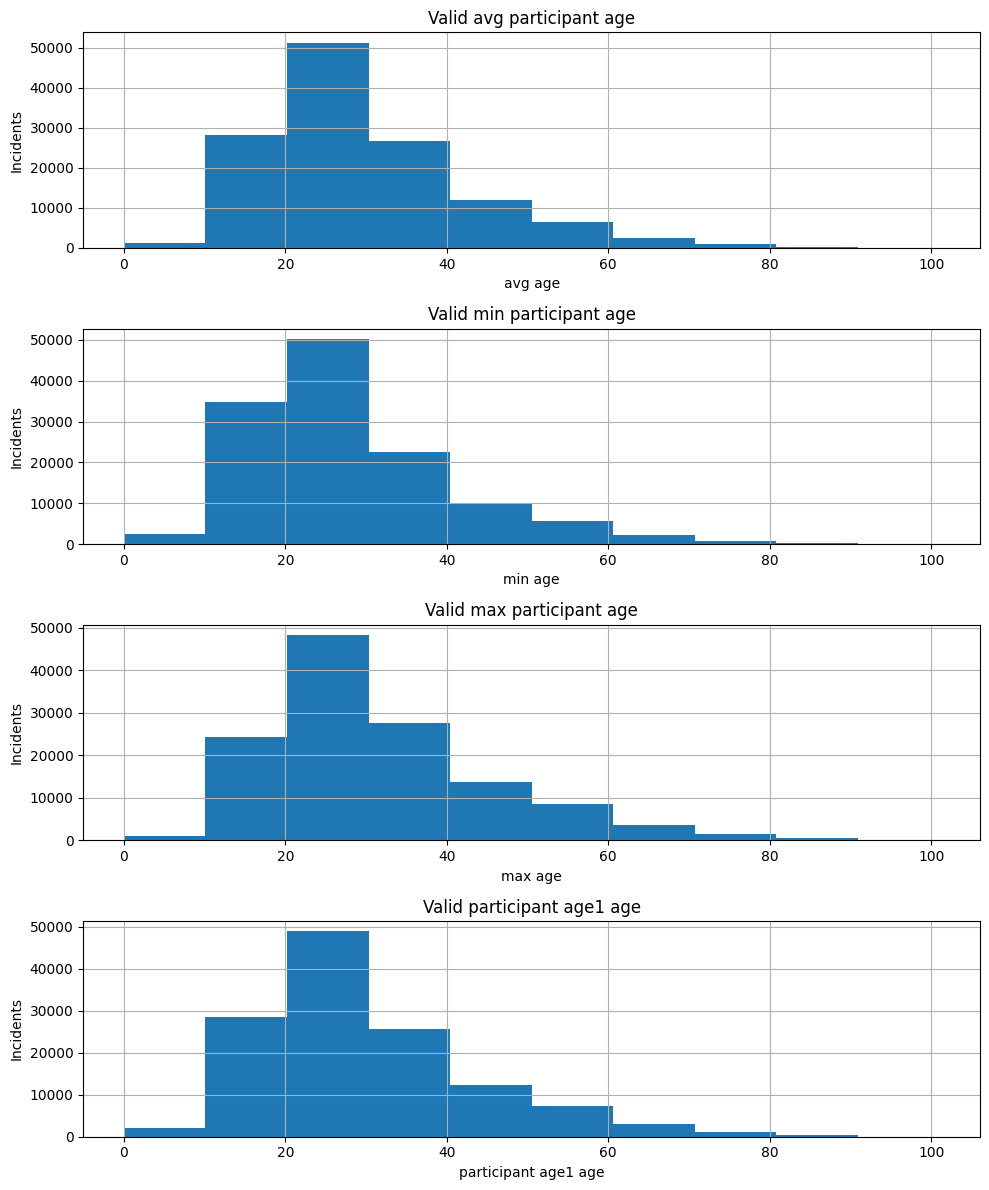

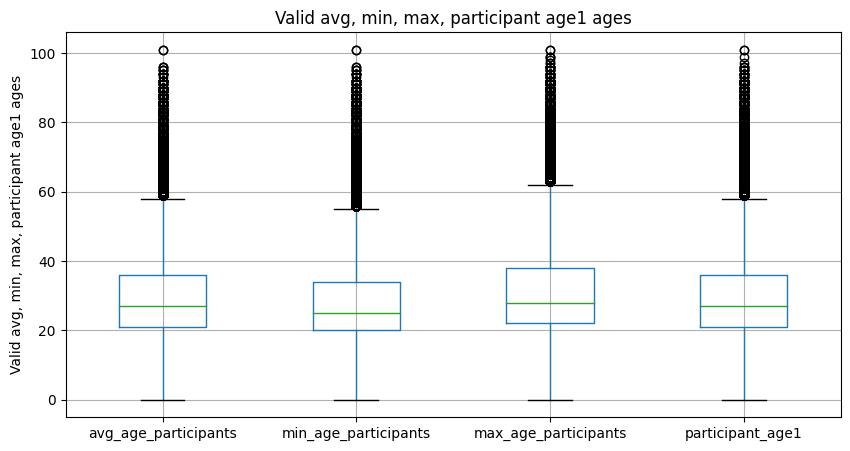

In [9]:
columns = ['avg_age_participants','min_age_participants','max_age_participants', 'participant_age1']
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["Valid avg participant age", "Valid min participant age", "Valid max participant age", "Valid participant age1 age"]
xlabels = ["avg age", "min age", "max age", "participant age1 age"]
ylabels = ["Incidents"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], figsize=(10,5))
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [10]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,129364.0,129364.0,129368.0,129365.0
mean,29.956526,30.248323,28.312079,31.741754
std,12.461089,13.344242,12.498503,13.704309
min,0.0,0.0,0.0,0.0
25%,21.0,21.0,20.0,22.0
50%,27.0,27.0,25.0,28.0
75%,36.0,36.0,34.0,38.0
max,101.0,101.0,101.0,101.0


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [11]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


## Date

Analysis and cleaning of the date attribute

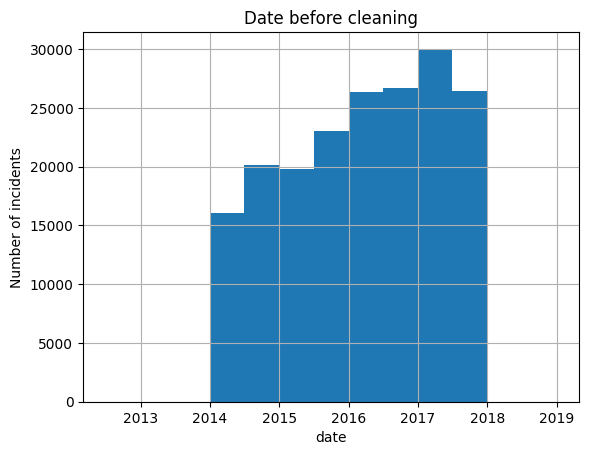

In [12]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

In [13]:
df['date'].dt.year.value_counts().sort_index()

date
2014    36248
2015    42804
2016    53051
2017    56365
Name: count, dtype: int64

Already in D.U., we considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data.

As already stated in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. Moreover, we decided also to drop temporarily records with year 2018 in the dataset (and probably analyze them separately after).
In data preparation we don't have further analysis to do and we left the date attribute unchanged. 

# Geographical info
('latitude', 'longitude', 'congressional_district', 'state_house_district', 'state_senate_district')

## Latitude and longitude

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates, because seeing also the notes and the incidents characteristics, the records with the same key represent the same incident  

In [14]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date', 'incident_characteristics1', 'notes']].value_counts()

latitude  longitude  date        incident_characteristics1                          notes                                            
29.7849   -95.3335   2016-05-16  Shot - Wounded/Injured                             1 inj.                                               2
38.5844   -121.4940  2014-03-20  ATF/LE Confiscation/Raid/Arrest                    ATF/LE                                               2
29.3663   -98.4417   2015-12-25  Shot - Dead (murder, accidental, suicide)          1 killed following argument                          2
43.2340   -86.2514   2017-02-28  Non-Shooting Incident                              Approximate date of sentencing.                      2
32.4125   -93.7938   2014-05-04  Possession (gun(s) found during commission of ...  armed robbery at McDonalds                           2
                                                                                                                                        ..
33.5667   -101.9170  2015-09-13 

In [15]:
print(f"records before cleaning: {len(df)}")
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(f"records after cleaning: {len(df)}")

records before cleaning: 188468


records after cleaning: 187543


In [16]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], Name: count, dtype: int64)

## Filling of missing values and outliers

We decide to repalce NaN value for latitude and longitude with the mean values for latitude and longitude in the same state and in the same city_or_county.

In [17]:
df.head(10)

,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,year,povertyPercentage,party,candidatevotes,totalvotes
83331,2017-02-04,maryland,Anne Arundel (county),<NA>,NaN,NaN,4,<NA>,31,17,...,0.0,1.0,shot in hip,Shot - Wounded/Injured,<NA>,2017.0,7.5,DEMOCRAT,237501,320650
84771,2016-01-14,maryland,Severn,2600 block of Annapolis Rd,NaN,NaN,3,<NA>,30,25,...,0.0,1.0,<NA>,Non-Shooting Incident,Possession of gun by felon or prohibited person,2016.0,7.1,DEMOCRAT,214640,339675
150390,2017-12-22,oklahoma,Tulsa,<NA>,NaN,NaN,1,73,11,28,...,0.0,2.0,Guns and drugs seized in raid on home.; 36...,Non-Shooting Incident,Gang involvement,2017.0,12.4,REPUBLICAN,1,1
157805,2015-03-03,maryland,Anne Arundel (county),<NA>,NaN,NaN,3,<NA>,<NA>,35,...,0.0,1.0,Multiple shooting locations by unnamed assaila...,Shots Fired - No Injuries,<NA>,2015.0,8.2,DEMOCRAT,128594,215946
158032,2015-10-11,maryland,Annapolis,896 Coachway,NaN,NaN,4,<NA>,31,50,...,0.0,1.0,<NA>,Non-Shooting Incident,Sex crime involving firearm,2015.0,8.2,DEMOCRAT,134628,191837
159203,2014-03-19,maryland,Curtis Bay (Orchard Beach),8043 Highpoint Rd,NaN,NaN,3,<NA>,31,25,...,0.0,2.0,<NA>,"Shot - Dead (murder, accidental, suicide)",Suicide^,2014.0,8.9,DEMOCRAT,128594,215946
159239,2014-09-26,maryland,Laurel,Whiskey Bottom Rd and Spring Rd,NaN,NaN,3,<NA>,<NA>,21,...,4.0,5.0,ar,Non-Shooting Incident,Brandishing/flourishing/open carry/lost/found,2014.0,8.9,DEMOCRAT,128594,215946
159250,2014-11-14,maryland,Pasadena,7800 block of Levy Ct,NaN,NaN,3,<NA>,31,21,...,0.0,2.0,1mvk,"Shot - Dead (murder, accidental, suicide)",<NA>,2014.0,8.9,DEMOCRAT,128594,215946
159403,2017-10-27,alaska,Palmer,E Knik River Road,NaN,NaN,0,<NA>,<NA>,31,...,0.0,1.0,Argument while in possession of gun,Non-Shooting Incident,Under the influence of alcohol or drugs (only ...,2017.0,11.8,REPUBLICAN,155088,308198
159405,2017-09-16,alaska,Fairbanks,McGrath Road,NaN,NaN,0,<NA>,<NA>,23,...,0.0,2.0,<NA>,Shots Fired - No Injuries,<NA>,2017.0,11.8,REPUBLICAN,155088,308198


In [18]:
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [19]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

## N participants [child, teen, adult] and n males and n females

As we observed in D.U., for n_participants[_child,_teen,_adult] there are outliers represented by enormous values. In data preparation, we decided to clean these data putting them to nan, using the max of the n_participants column (which has no significantly big values).

In [20]:
# n_participants has no evident outliers as seen in D.U., we use max participants as threshold value to filter out the outliers
max_participants = df['n_participants'].max()

df.loc[(df["n_participants_child"] > max_participants), "n_participants_child"] = np.nan
df.loc[(df["n_participants_teen"] > max_participants), "n_participants_teen"] = np.nan
df.loc[(df["n_participants_adult"] > max_participants), "n_participants_adult"] = np.nan

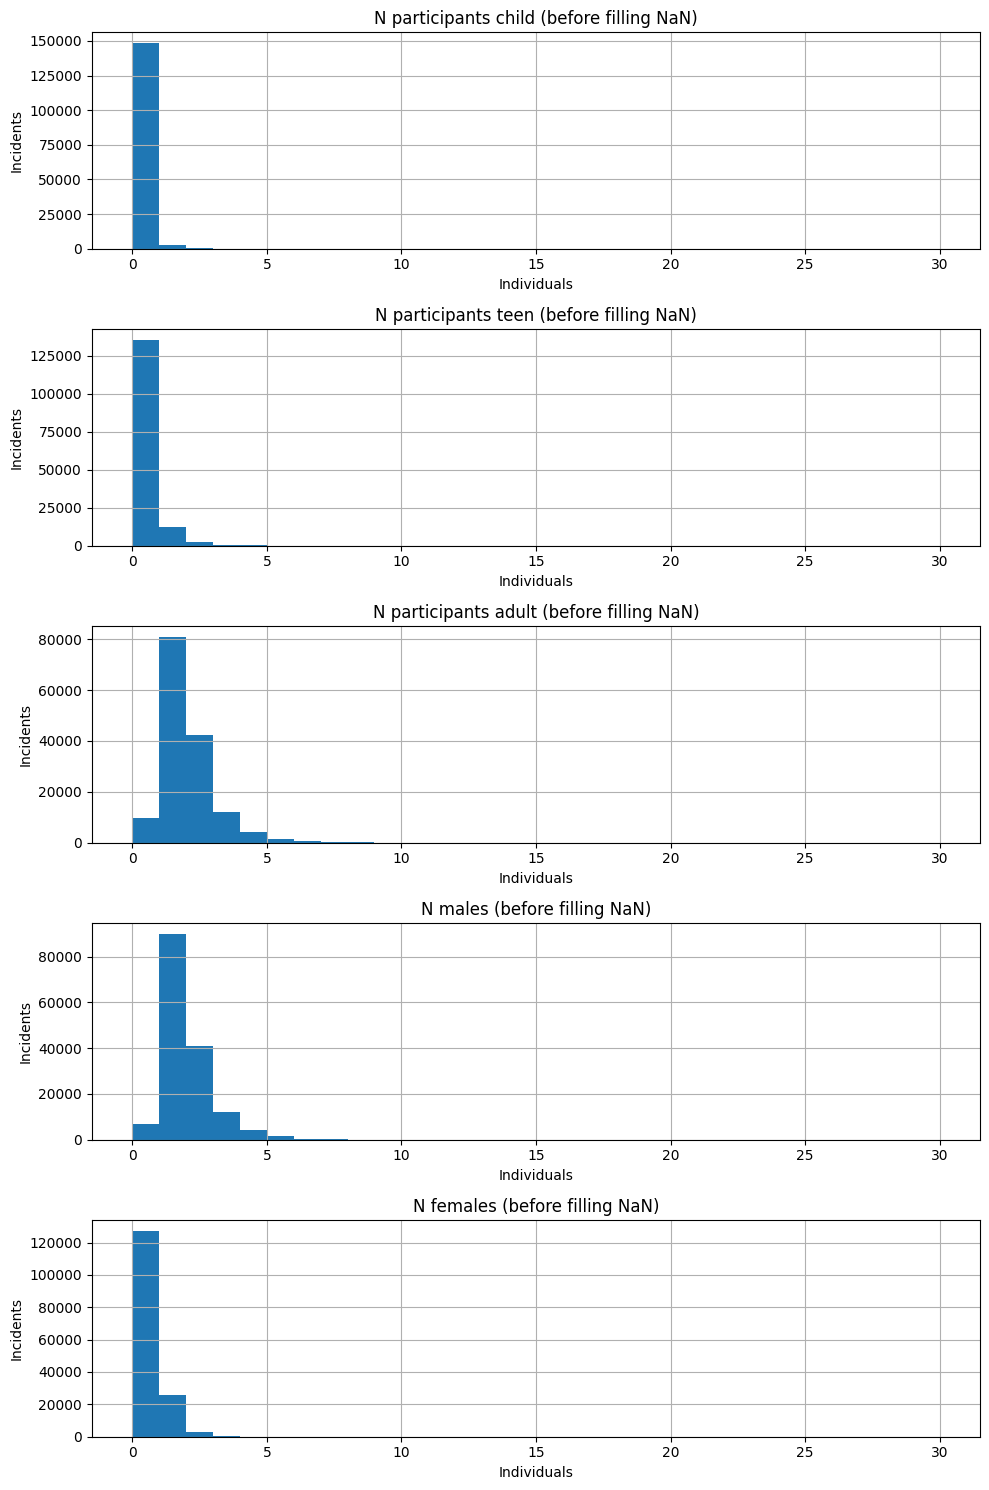

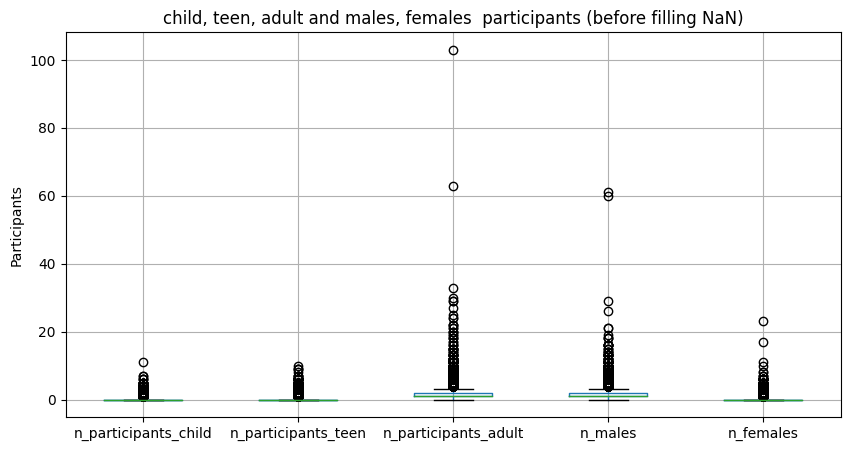

In [21]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (before filling NaN)", "N participants teen (before filling NaN)", "N participants adult (before filling NaN)", "N males (before filling NaN)", "N females (before filling NaN)"]
xlabels = ["Individuals"] * 5
ylabels = ["Incidents"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax , bins=[i for i in range(0,31,1)])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"],  figsize=(10,5))
plt.title("child, teen, adult and males, females  participants (before filling NaN)")
plt.ylabel("Participants")
plt.show()

In [22]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,151878.0,151878.0,151878.0,156943.0,156943.0
mean,0.024882,0.140685,1.542962,1.526491,0.216346
std,0.191763,0.465165,1.093161,1.000591,0.494894
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,11.0,10.0,103.0,61.0,23.0


If n participants 0, fill all the other info about the number of people to 0

In [23]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

We try to reconstruct the n_participants attribute values in the different cases:

1- when n participants number was non-coherent with the sum of n_[males,females] and n_participants_[child,teen,adult] (when the sum of the values of these attributes is equal), we substitute it with the sum of n[_males,females] (the same would have been with substituting with n_participants_[child,teen,adult])


In [24]:
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

print(f"participants !=, n age = n gender:  {len(df[condition])}")
# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

participants !=, n age = n gender:  5039


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
159250,1.0,1.0,0.0,0,0,1
166441,1.0,1.0,0.0,0,0,1
57,1.0,1.0,0.0,0,0,1
63,1.0,0.0,1.0,0,0,1
170,1.0,1.0,0.0,0,0,1
...,...,...,...,...,...,...
188421,2.0,2.0,0.0,0,0,2
188438,2.0,2.0,0.0,0,0,2
188450,1.0,1.0,0.0,0,0,1
188617,2.0,1.0,1.0,0,0,2


2- If there were inconsistency between n_participants and n_participants_[child,teen,adult] or n_participants_[males,females], we set the correspondent values of these attributes to nan.

In [25]:
df['n_participants_gender'] = df['n_females'] + df['n_males']
df['n_participants_age'] = df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']

# null values can be ambiguous, we ignore them for now
df['n_participants_gender'] = df[df['n_participants_gender'].notna()]['n_participants_gender']
df['n_participants_age'] = df[df['n_participants_age'].notna()]['n_participants_age']


condition = (
    ((df['n_participants_gender']) != (df['n_participants_age']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_participants_gender'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_age'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))


Number of male e female != child + teen + adult:  12652
Same condition as before but with n participants == female + male: 8192
Same condition as before but with n participants == child + teen + adult: 3967
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 493


In [26]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females","n_participants_age","n_participants_gender"]] = np.nan
df.loc[condition2, ["n_males","n_females","n_participants_gender"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_age"] != df["n_participants"],["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_gender"] != df["n_participants"],["n_males","n_females", "n_participants_gender"]] = np.nan

df.drop(columns=['n_participants_age', 'n_participants_gender'], inplace=True)

In [27]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187543 entries, 83331 to 188720
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  163832 non-null  Int64  
 1   n_participants_teen   163832 non-null  Int64  
 2   n_participants_adult  163832 non-null  Int64  
 3   n_males               172161 non-null  Float64
 4   n_females             172161 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 9.5 MB


In [28]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

Then we fill each missing value in each attributes with the mean values grouped by the number of participants such that the sum of n_[males,females] and n_participants_[child,teen,adult] doesn't exceed the number of participants  

In [29]:
#putting in males the first element from males_females
group_by = df.groupby("n_participants",group_keys=False)
for name, group in group_by:
    males_mean = group["n_males"].mean()
    females_mean = group["n_females"].mean()
    participants_child_mean = group["n_participants_child"].mean()
    participants_teen_mean = group["n_participants_teen"].mean()
    participants_adult_mean = group["n_participants_adult"].mean()

    if (pd.notna(males_mean) and pd.notna(females_mean)):
        df.loc[(df["n_males"].isna()) & (df["n_participants"] == name),"n_males"] = np.round(males_mean,0)
        df.loc[(df["n_females"].isna()) & (df["n_participants"] == name),"n_females"] = np.round(females_mean,0)

    if (pd.notna(participants_child_mean) and pd.notna(participants_teen_mean) and pd.notna(participants_adult_mean)):
        df.loc[(df["n_participants_child"].isna()) & (df["n_participants"] == name),"n_participants_child"] = np.round(participants_child_mean,0)
        df.loc[(df["n_participants_teen"].isna()) & (df["n_participants"] == name),"n_participants_teen"] = np.round(participants_teen_mean,0)
        df.loc[(df["n_participants_adult"].isna()) & (df["n_participants"] == name),"n_participants_adult"] = np.round(participants_adult_mean,0)


In [30]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


In [31]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187543 entries, 83331 to 188720
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  187539 non-null  Int64  
 1   n_participants_teen   187539 non-null  Int64  
 2   n_participants_adult  187539 non-null  Int64  
 3   n_males               187534 non-null  Float64
 4   n_females             187534 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 9.5 MB


All the data in which we can't reconstruct the mean were few (only 8) and for this reason were dropped

In [32]:
df[(df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna())][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
11824,47.0,<NA>,<NA>,<NA>,<NA>,<NA>
31362,37.0,<NA>,<NA>,<NA>,<NA>,<NA>
32749,24.0,<NA>,<NA>,0,0,24
34999,103.0,<NA>,<NA>,0,0,103
36808,24.0,<NA>,<NA>,0,0,24
64633,35.0,<NA>,<NA>,<NA>,<NA>,<NA>
131171,24.0,<NA>,<NA>,0,0,24
177440,52.0,<NA>,<NA>,<NA>,<NA>,<NA>
179378,30.0,<NA>,<NA>,0,0,30


In [33]:
df = df[~((df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna()))]

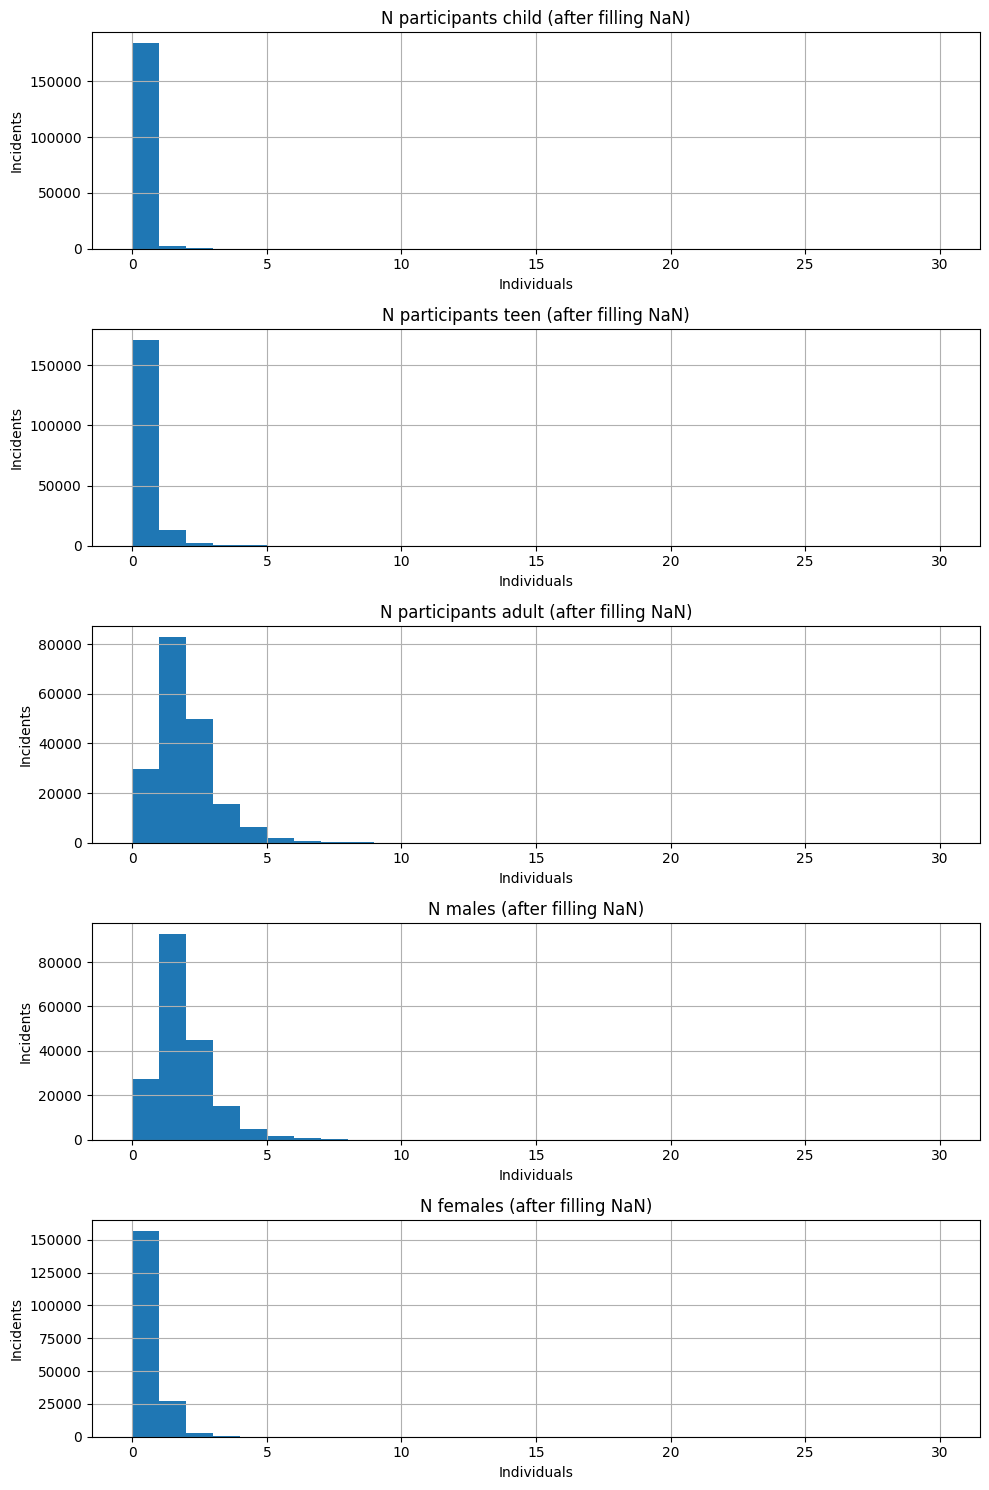

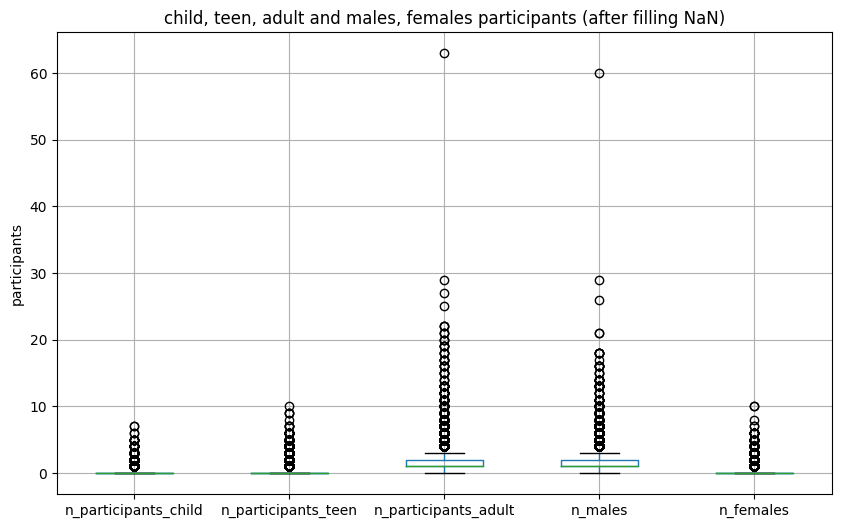

In [34]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (after filling NaN)", "N participants teen (after filling NaN)", "N participants adult (after filling NaN)", "N males (after filling NaN)", "N females (after filling NaN)"]
xlabels = ["Individuals"] * 5
ylabels = ["Incidents"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax, bins=[i for i in range(0,31,1)])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult",  "n_males", "n_females"], figsize=(10,6))
plt.title("child, teen, adult and males, females participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [35]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,187534.0,187534.0,187534.0,187534.0,187534.0
mean,0.019255,0.112428,1.451971,1.397587,0.186068
std,0.167117,0.416448,1.146867,1.079249,0.457206
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,7.0,10.0,63.0,60.0,10.0


As we can see from the plots before and after filling NaN values, there is no relevant change in the distributions of these variables 

## N killed, injured, arrested, unharmed

N killed and N injured have no NaN values after the previous steps of cleaning, so we proceed to fix N arrested and N unharmed missing values.

In [36]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 83331 to 188720
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187534 non-null  Float64
 1   n_injured   187534 non-null  Float64
 2   n_arrested  164238 non-null  Float64
 3   n_unharmed  164238 non-null  Float64
dtypes: Float64(4)
memory usage: 7.9 MB


We check if each column in n_[killed, injured, arrested, unharmed] does not exceed the n of participants to that incident and the result is that no record exceeds this number.  

We observe that also n_killed and n_injured has some values abouve the n_participants of that incidents. We proceed to fix these values to NaN and fix them

In [37]:
columns_to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
for column in columns_to_check:
    df.loc[df[column] > df['n_participants'], column] = np.nan

In [38]:
df[columns_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 83331 to 188720
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187521 non-null  Float64
 1   n_injured   187304 non-null  Float64
 2   n_arrested  164143 non-null  Float64
 3   n_unharmed  163604 non-null  Float64
dtypes: Float64(4)
memory usage: 7.9 MB


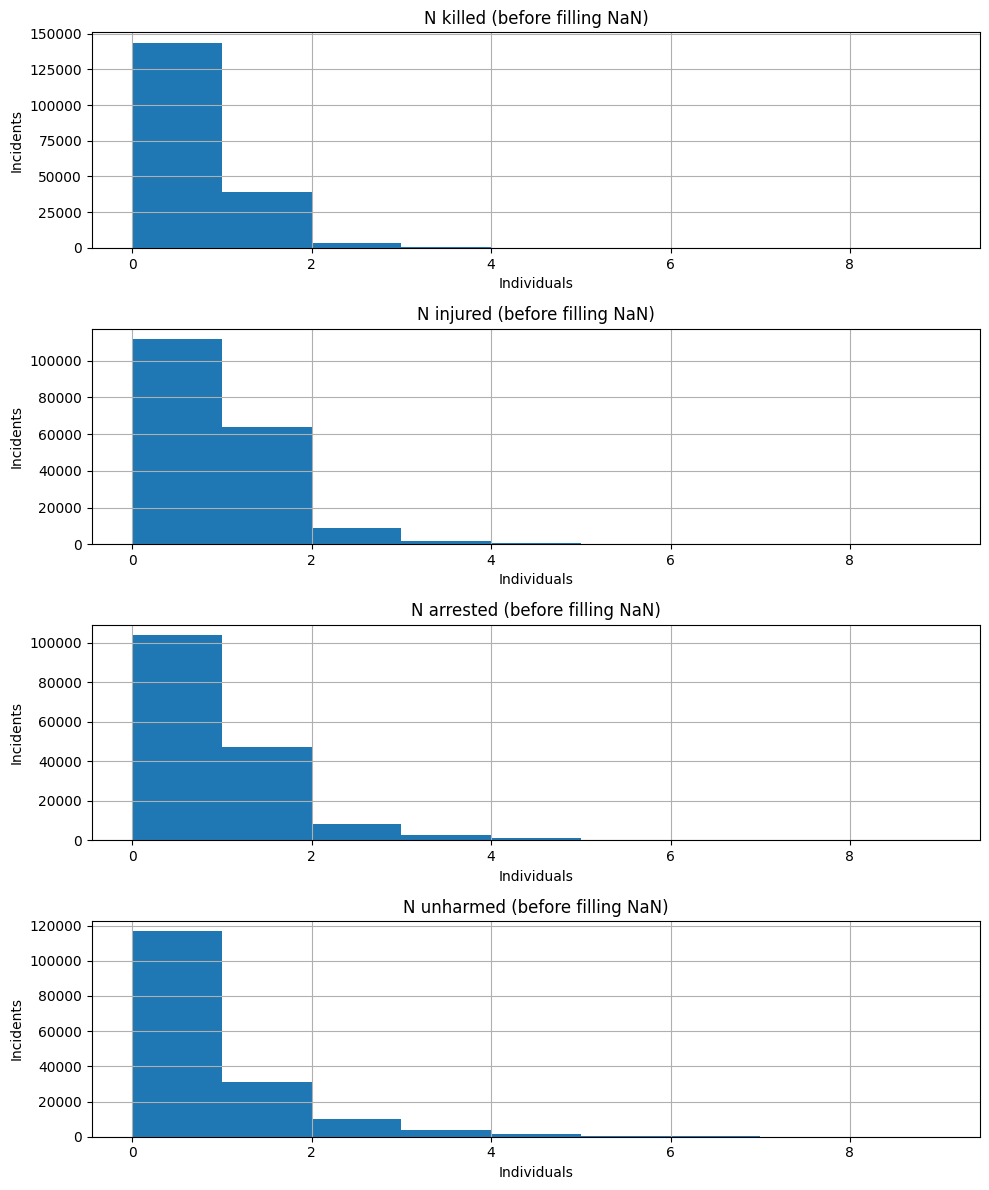

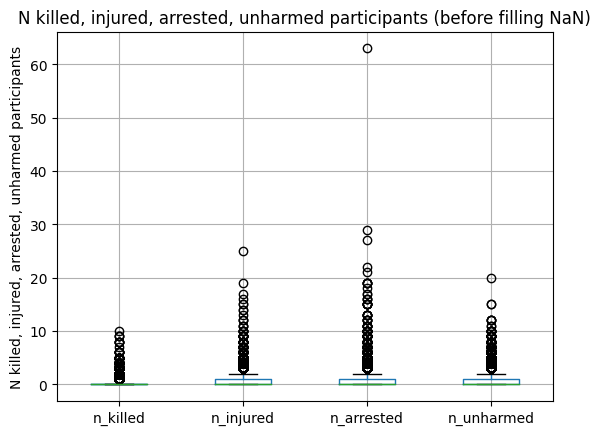

In [39]:
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["N killed (before filling NaN)", "N injured (before filling NaN)", "N arrested (before filling NaN)", "N unharmed (before filling NaN)"]
xlabels = ["Individuals"] * 4
ylabels = ["Incidents"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax, bins=[i for i in range(0,10,1)])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (before filling NaN)")
plt.ylabel("N killed, injured, arrested, unharmed participants")
plt.show()

In [40]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,187521.0,187304.0,164143.0,163604.0
mean,0.262029,0.488009,0.495873,0.443987
std,0.513434,0.710006,0.853363,0.87299
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,10.0,25.0,63.0,20.0


We put to 0 arrested and unharmed in all the cases in which there is 0 participants.

In [41]:
df.loc[df["n_participants"] == 0, ['n_arrested', 'n_unharmed']] = 0

Fill the remaining null values with the mean

In [42]:
def fillna_group_arrested_unharmed(group):
    group["n_killed"] = group["n_killed"].fillna(np.round(group["n_killed"].mean(),0))
    group["n_injured"] = group["n_injured"].fillna(np.round(group["n_injured"].mean(),0))
    group["n_arrested"] = group["n_arrested"].fillna(np.round(group["n_arrested"].mean(),0))
    group["n_unharmed"] = group["n_unharmed"].fillna(np.round(group["n_unharmed"].mean(),0))
    return group

In [43]:
df = df.groupby("n_participants").apply(fillna_group_arrested_unharmed).reset_index(drop=True)

In [44]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187534 non-null  Float64
 1   n_injured   187534 non-null  Float64
 2   n_arrested  187534 non-null  Float64
 3   n_unharmed  187534 non-null  Float64
dtypes: Float64(4)
memory usage: 6.4 MB


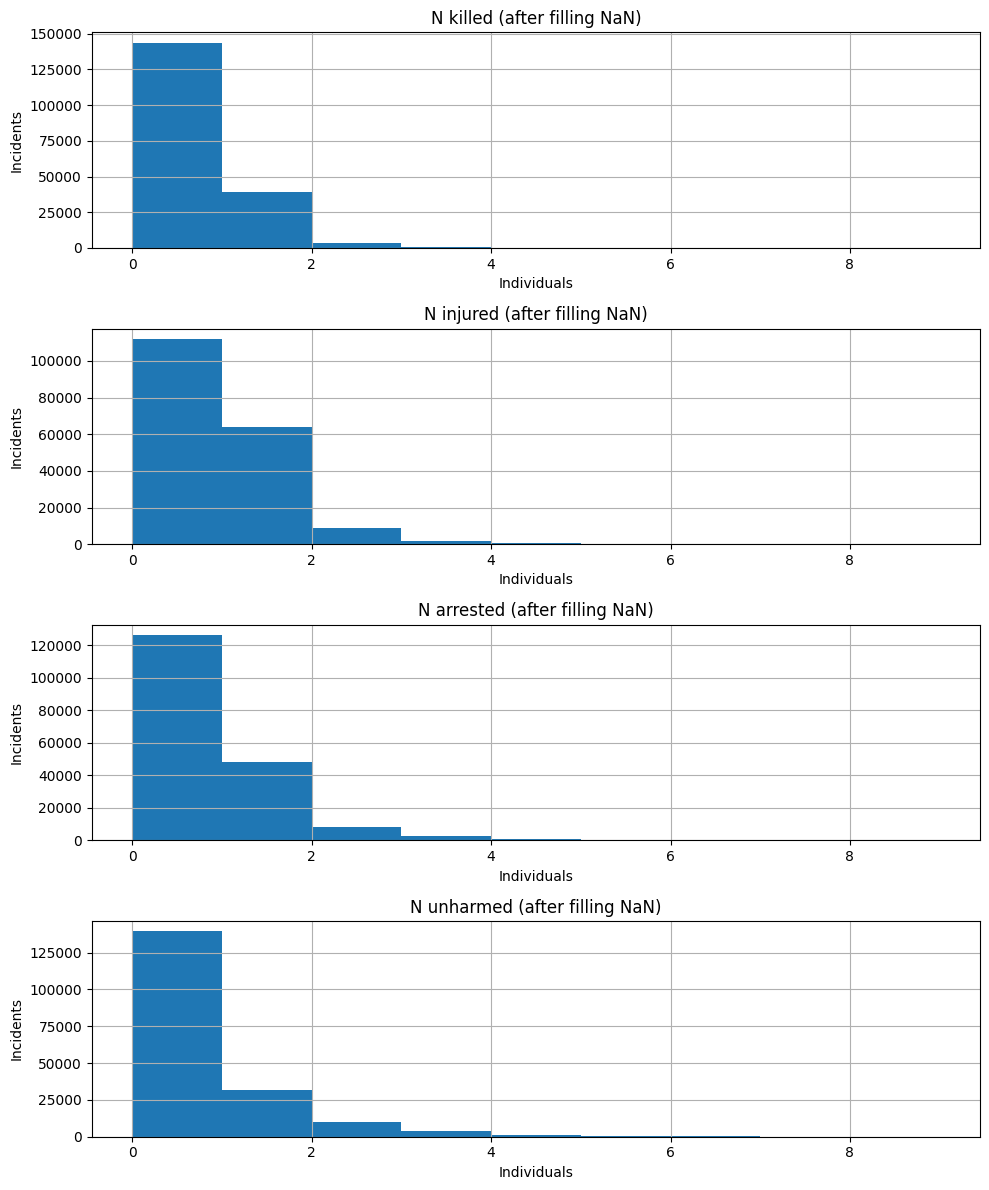

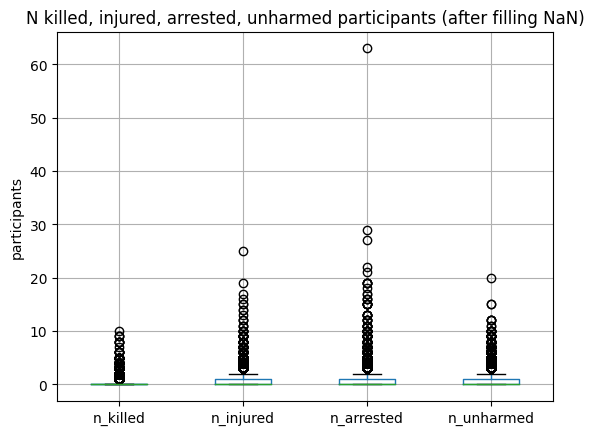

In [45]:
fig, axs = plt.subplots(4, figsize=(10, 12))  

titles = ["N killed (after filling NaN)", "N injured (after filling NaN)", "N arrested (after filling NaN)", "N unharmed (after filling NaN)"]
xlabels = ["Individuals"] * 4
ylabels = ["Incidents"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax, bins=[i for i in range(0,10,1)])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [46]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,187534.0,187534.0,187534.0,187534.0
mean,0.262011,0.487666,0.439862,0.393811
std,0.513421,0.709803,0.815828,0.830017
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,10.0,25.0,63.0,20.0


As we can see from the plots before and after filling NaN values, there is no major change in the distributions of these variables 

# Incident characteristics 1

In [47]:
df['incident_characteristics1'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 187534 entries, 0 to 187533
Series name: incident_characteristics1
Non-Null Count   Dtype 
--------------   ----- 
187274 non-null  string
dtypes: string(1)
memory usage: 1.4 MB


To fill the missing values, we subdivide them in subcategories, assuming that they are mostly incidents involving guns

In [48]:
df_car = df[df['incident_characteristics1'].isna()]

In [49]:
shooting_condition = (df_car['notes'].str.contains('shot|shoot|shooting|gun|sniper|bullet|firearm|shooter|rifle|arm|shoulder|assault', na=False, case=False)) & ((df_car['n_injured'] == 0) & (df_car['n_killed'] == 0))
shooting_injured = ((df_car['n_injured'] > 0) & (df_car['n_killed'] == 0))
killed_condition =  (df_car['n_killed'] > 0)
airp_condition = (df_car['notes'].str.contains('airport|international|intercontinental', na=False, case=False))
no_notes_car2_condition = df_car['notes'].isna() & df_car['incident_characteristics2'].isna() & ~(shooting_condition | shooting_injured | killed_condition | airp_condition)

In [50]:
print(f"n. incidents with no characteristics1:  {df_car.value_counts(dropna=False).sum()}")
print(f"n. incidents without notes or characteristics2:  {df_car[no_notes_car2_condition].value_counts(dropna=False).sum()}")
print(f"n. incidents involving airport control (TSA Action):  {df_car[airp_condition].value_counts(dropna=False).sum()}")
print(f"n. incidents involving shootings (no injuries):  {df_car[shooting_condition].value_counts(dropna=False).sum()}")
print(f"n. incidents involving shootings (only injuries):  {df_car[shooting_injured].value_counts(dropna=False).sum()}")
print(f"n. incidents involving shootings (>=1 deaths):  {df_car[killed_condition].value_counts(dropna=False).sum()}")
print(f"n. remaining incidents:  {df_car[~(no_notes_car2_condition|shooting_condition|shooting_injured|killed_condition)].value_counts(dropna=False).sum()}")

n. incidents with no characteristics1:  260
n. incidents without notes or characteristics2:  20
n. incidents involving airport control (TSA Action):  4
n. incidents involving shootings (no injuries):  71
n. incidents involving shootings (only injuries):  119
n. incidents involving shootings (>=1 deaths):  33
n. remaining incidents:  17


In [51]:
df_car[(no_notes_car2_condition) & ~(no_notes_car2_condition|shooting_condition|shooting_injured|killed_condition) & (df_car['n_killed'] > 0) & (df_car['n_injured'] > 0)]

,date,state,city_or_county,address,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,...,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,year,povertyPercentage,party,candidatevotes,totalvotes


We fill missing value for characteristics1 with each category found from the notes or n_killed or n_injured. In case of no notes or remaining incidents we fill with Shots Fired- No Injuries, as they have no people reported killed or injured and we do not want to affect the distribution

In [52]:
non_zero_participants_condition = (df['incident_characteristics1'].isna())
remaining_condition = ~(no_notes_car2_condition|shooting_condition|shooting_injured|killed_condition|airp_condition)

df.loc[non_zero_participants_condition & shooting_condition, 'incident_characteristics1'] = "Shots Fired - No Injuries"
df.loc[non_zero_participants_condition & shooting_injured, 'incident_characteristics1'] = "Shot - Wounded/Injured"
df.loc[non_zero_participants_condition & killed_condition, 'incident_characteristics1'] = "Shot - Dead (murder, accidental, suicide)"
df.loc[non_zero_participants_condition & airp_condition, 'incident_characteristics1'] = "TSA Action"
df.loc[non_zero_participants_condition & no_notes_car2_condition, 'incident_characteristics1'] = "Shots Fired - No Injuries"
df.loc[non_zero_participants_condition & remaining_condition, 'incident_characteristics1'] = "Shots Fired - No Injuries"

# Incident characteristics 2

In [53]:
df['incident_characteristics2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 187534 entries, 0 to 187533
Series name: incident_characteristics2
Non-Null Count   Dtype 
--------------   ----- 
111662 non-null  string
dtypes: string(1)
memory usage: 1.4 MB


In [54]:
print(f" percentage of null values: {df['incident_characteristics2'].isna().sum() / len(df['incident_characteristics2'])}")

 percentage of null values: 0.40457730331566544


In [55]:
set(df['incident_characteristics1'].unique()) - set(df['incident_characteristics2'].unique()) 

{'Shot - Wounded/Injured'}

In [56]:
df[df['incident_characteristics1'].notna()][['incident_characteristics1','incident_characteristics2']].value_counts(dropna=False).head(3)

incident_characteristics1                  incident_characteristics2
Shot - Wounded/Injured                     <NA>                         36639
Shot - Dead (murder, accidental, suicide)  <NA>                         18795
Shots Fired - No Injuries                  <NA>                         12555
Name: count, dtype: int64

Since incident_characteristics2 has 40% of missing values and add only further details (have all classes of incident_characteristics1 except "Shot - Wounded/Injured" + other more detailed classes) that we consider useless for our analysis, we decided to drop it. 

In [57]:
df.drop(columns=['incident_characteristics2'], inplace=True)

# Correlation Matrix Analysis

In [58]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')

<Axes: >

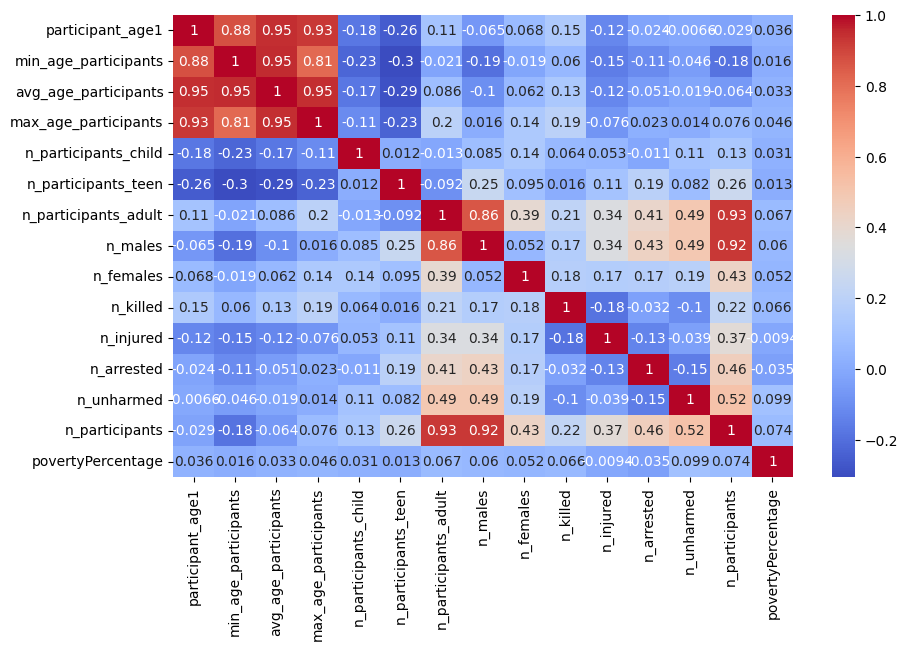

In [59]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

As resulted from the plotting of correlation matrix, we can see that attributes related to the age i.e. participant_age1, min_age_participants, 	avg_age_participants, max_age_participants are all high correlated.
We decided to drop everything except avg_age_participants which has the most high correlation w.r.t. other attributes (>0.90) and gives us more general information about all the participants (w.r.t. e.g. participant_age1, which takes the age of one random person involved in the incident.)

Deleting participant_age1, also participant_age_group1 and participant_gender1 becomes useless (also because these information can be inferred respectively from n_participant_[child,teen,adult] and n_[males,females]), so we delete also these attributes. 

We notice that also n_participants, n_participants_adult, n_males are highly correlated.  
We observe that we can derive n_participants_adult, n_males from n_participants and viceversa, as n_participants_adult + n_participants_teen + n_participants_child = n_males + n_females = n_participants, so we decide to keep the most general information, so only n_participants     

In [60]:
df[(df['n_participants'] != (df['n_males'] + df['n_females'])) | (df['n_participants'] != (df['n_participants_child'] + df['n_participants_teen'] + df['n_participants_adult']))]

,date,state,city_or_county,address,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,...,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,year,povertyPercentage,party,candidatevotes,totalvotes


Before dropping all the attributes, we proceed to fill also avg_age_participants

## Filling missing values for avg_age_participants

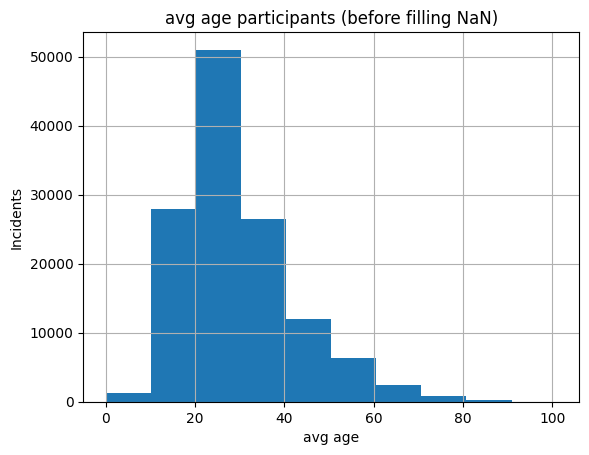

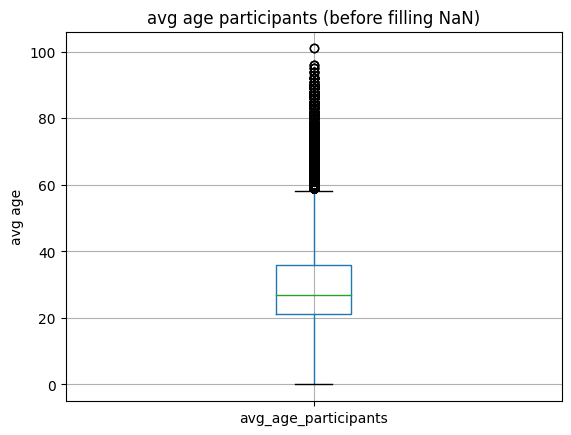

In [61]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Incidents")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.ylabel("avg age")
plt.show()

In [62]:
df["avg_age_participants"].describe()

count     128775.0
mean     29.955977
std      12.460553
min            0.0
25%           21.0
50%           27.0
75%           36.0
max          101.0
Name: avg_age_participants, dtype: Float64

We decide to fill the missing values of avg_age_participants with the mean.

In particular we assume that:
- if there is more than 1 adult, fill the null value with the general mean age(as 1. the mean of n_participants is around 1.5 and 2. n_participants and n_participants_adult is high correlated), 
- if no adult and at least 1 teen is present, fill the null value with avg age of teens (see 1. above)
- if no adult and no teen are present, fill the null value value with the avg age of children  

In [63]:
mean_age_before_correction = df["avg_age_participants"].mean()
df_adult = df[df["n_participants_adult"] > 0].copy() 
df_teen = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] > 0)].copy()
df_child = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] == 0) & (df["n_participants_child"] > 0)].copy()
df_remainder = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] == 0) & (df["n_participants_child"] == 0)].copy()



df_adult["avg_age_participants"] = df_adult["avg_age_participants"].fillna(round(mean_age_before_correction,0))
df_teen["avg_age_participants"] = df_teen["avg_age_participants"].fillna(round(df_teen["avg_age_participants"].mean(),0))
df_child["avg_age_participants"] = df_child["avg_age_participants"].fillna(round(df_child["avg_age_participants"].mean(),0))


df = pd.concat([df_adult, df_teen, df_child, df_remainder])

df['avg_age_participants'].info()

<class 'pandas.core.series.Series'>
Index: 187534 entries, 20871 to 20869
Series name: avg_age_participants
Non-Null Count   Dtype  
--------------   -----  
166664 non-null  Float64
dtypes: Float64(1)
memory usage: 3.0 MB


The remaining records to fill have all participants information equals to 0, so we decided to drop them to not affect the distribution of the age 

In [64]:
print(len(df_remainder))
#drop values from df_remainder
print(df.shape)
df = df.dropna(subset=["avg_age_participants"])
print(df.shape)


20870
(187534, 30)
(166664, 30)


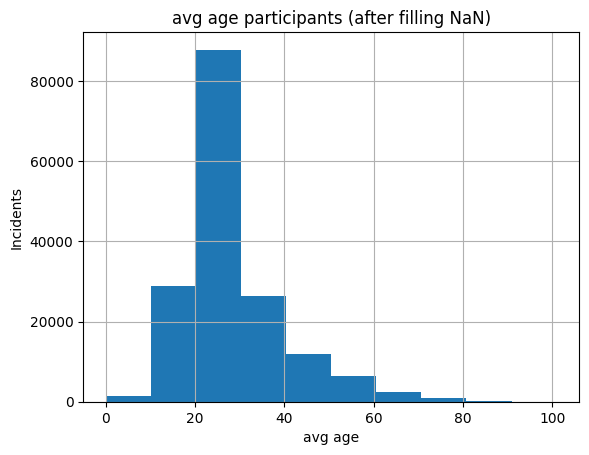

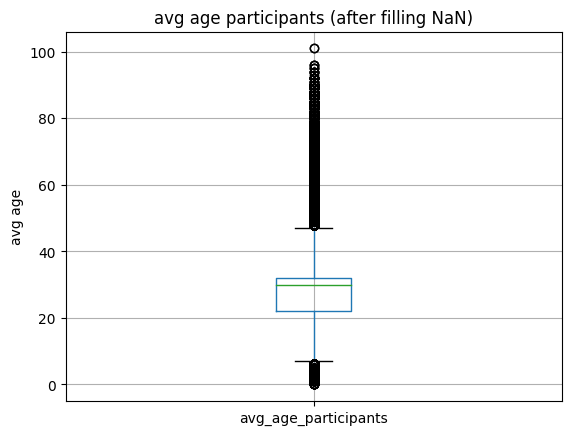

In [65]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Incidents")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.ylabel("avg age")
plt.show()

In [66]:
outlier_lowerb = df[df["avg_age_participants"] < (23-(31-23)*1.5)]['avg_age_participants'].count()
outlier_upperb = df[df["avg_age_participants"] > (31+(31-23)*1.5)]['avg_age_participants'].count()
outlier_lowerb + outlier_upperb

19143

We left these outliers because they are all between 0 and 120, so all possible ages, we maintain it and see how clustering analysis goes

In [67]:
df["avg_age_participants"].describe()

count     166664.0
mean     29.873656
std      11.016848
min            0.0
25%           22.0
50%           30.0
75%           32.0
max          101.0
Name: avg_age_participants, dtype: Float64

## Dropping all high correlated attributes

In [68]:
df.drop(columns=['participant_age1', 'min_age_participants', 'max_age_participants', 'participant_age_group1', 'participant_gender1', 'n_participants_adult', 'n_males'], inplace=True)

# Definition of Indicators

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166664 entries, 20871 to 185349
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  string        
 2   city_or_county             166664 non-null  string        
 3   address                    154871 non-null  string        
 4   latitude                   166664 non-null  float64       
 5   longitude                  166664 non-null  float64       
 6   congressional_district     166664 non-null  Int64         
 7   avg_age_participants       166664 non-null  Float64       
 8   n_participants_child       166664 non-null  Int64         
 9   n_participants_teen        166664 non-null  Int64         
 10  n_females                  166664 non-null  Float64       
 11  n_killed                   166664 non-null  Float64  

With a particular focus on features related to deaths and injuries, which are in our opinion the most critical features to explore, we defined additional features 
such as:

- the gravity of the accident i.e. how many people were killed or injured in a particular accident

At a general level, we calculated:
- the number of women and minors involved in an accident compared to the number of participants
- the number of deaths, injuries, arrests and survivors compared to the number of participants
- percentage of victory of the majority party, which together with the poverty percentage, shows us the social situation in each state 

To better explore the phenomenon of deaths and injuries, we went into more detail by defining:
- difference in the number of deaths and injuries and participants of an accident compared to the average of a district congress in each year

### Incident gravity

In [70]:
df['incident_gravity'] = df['n_killed'] + df['n_injured']

### Incident ratios

In [71]:
#Ratio of females people in the incidents w.r.t. the number of participants
df["females_rate"] = df["n_females"] / df["n_participants"]
df.loc[np.isnan(df["females_rate"]),"females_rate"] = 0

#Ratio of minors people in the incidents w.r.t. the number of participants
df["minor_rate"] = (df["n_participants_child"]+df["n_participants_teen"]) / df["n_participants"]
df.loc[np.isnan(df["minor_rate"]),"minor_rate"] = 0

#Ratio of arrested people in the incidents w.r.t. the number of participants
df["arrested_rate"] = df["n_arrested"] / df["n_participants"]
df.loc[np.isnan(df["arrested_rate"]),"arrested_rate"] = 0

#Ratio of survival people in the incidents w.r.t. the number of participants
df["survival_rate"] = df["n_unharmed"] / df["n_participants"]
df.loc[np.isnan(df["survival_rate"]),"survival_rate"] = 0

# Percentage of votes of the winning party
df['winning_party_percentage'] = df['candidatevotes'] / df['totalvotes']
df.loc[np.isnan(df["winning_party_percentage"]),"winning_party_percentage"] = 0

#Ratio of killed people in the incidents w.r.t. the number of participants
df["killed_rate"] = df["n_killed"] / df["n_participants"]
df.loc[np.isnan(df["killed_rate"]),"killed_rate"] = 0

#Ratio of injured people in the incidents w.r.t. the number of participants
df["injured_rate"] = df["n_injured"] / df["n_participants"]
df.loc[np.isnan(df["injured_rate"]),"injured_rate"] = 0



### Incidents per district

In [72]:
#How many killed people have been involved w.r.t the total killed people in the same congressional district in a given date
df["killed_disp_per_district"] = df["n_killed"] /  df.groupby(["state", "congressional_district", df.date.dt.year])["n_killed"].transform("mean")
df.loc[np.isnan(df["killed_disp_per_district"]),"killed_disp_per_district"] = 0

#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["injured_disp_per_district"] = df["n_injured"] /  df.groupby([ "state", "congressional_district", df.date.dt.year])["n_injured"].transform("mean")
df.loc[np.isnan(df["injured_disp_per_district"]),"injured_disp_per_district"] = 0

#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["part_disp_per_district"] = df["n_participants"] /  df.groupby([ "state", "congressional_district", df.date.dt.year])["n_participants"].transform("mean")
df.loc[np.isnan(df["part_disp_per_district"]),"part_disp_per_district"] = 0

### Correlation and distribution analysis

In [73]:
col_to_plot = [
 'females_rate',
 'minor_rate',
 'killed_rate',
 'injured_rate',
 'arrested_rate',
 'survival_rate',
 'incident_gravity',
 'winning_party_percentage',
 'killed_disp_per_district',
 'injured_disp_per_district',
 'part_disp_per_district',
 ]

corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')

<Axes: >

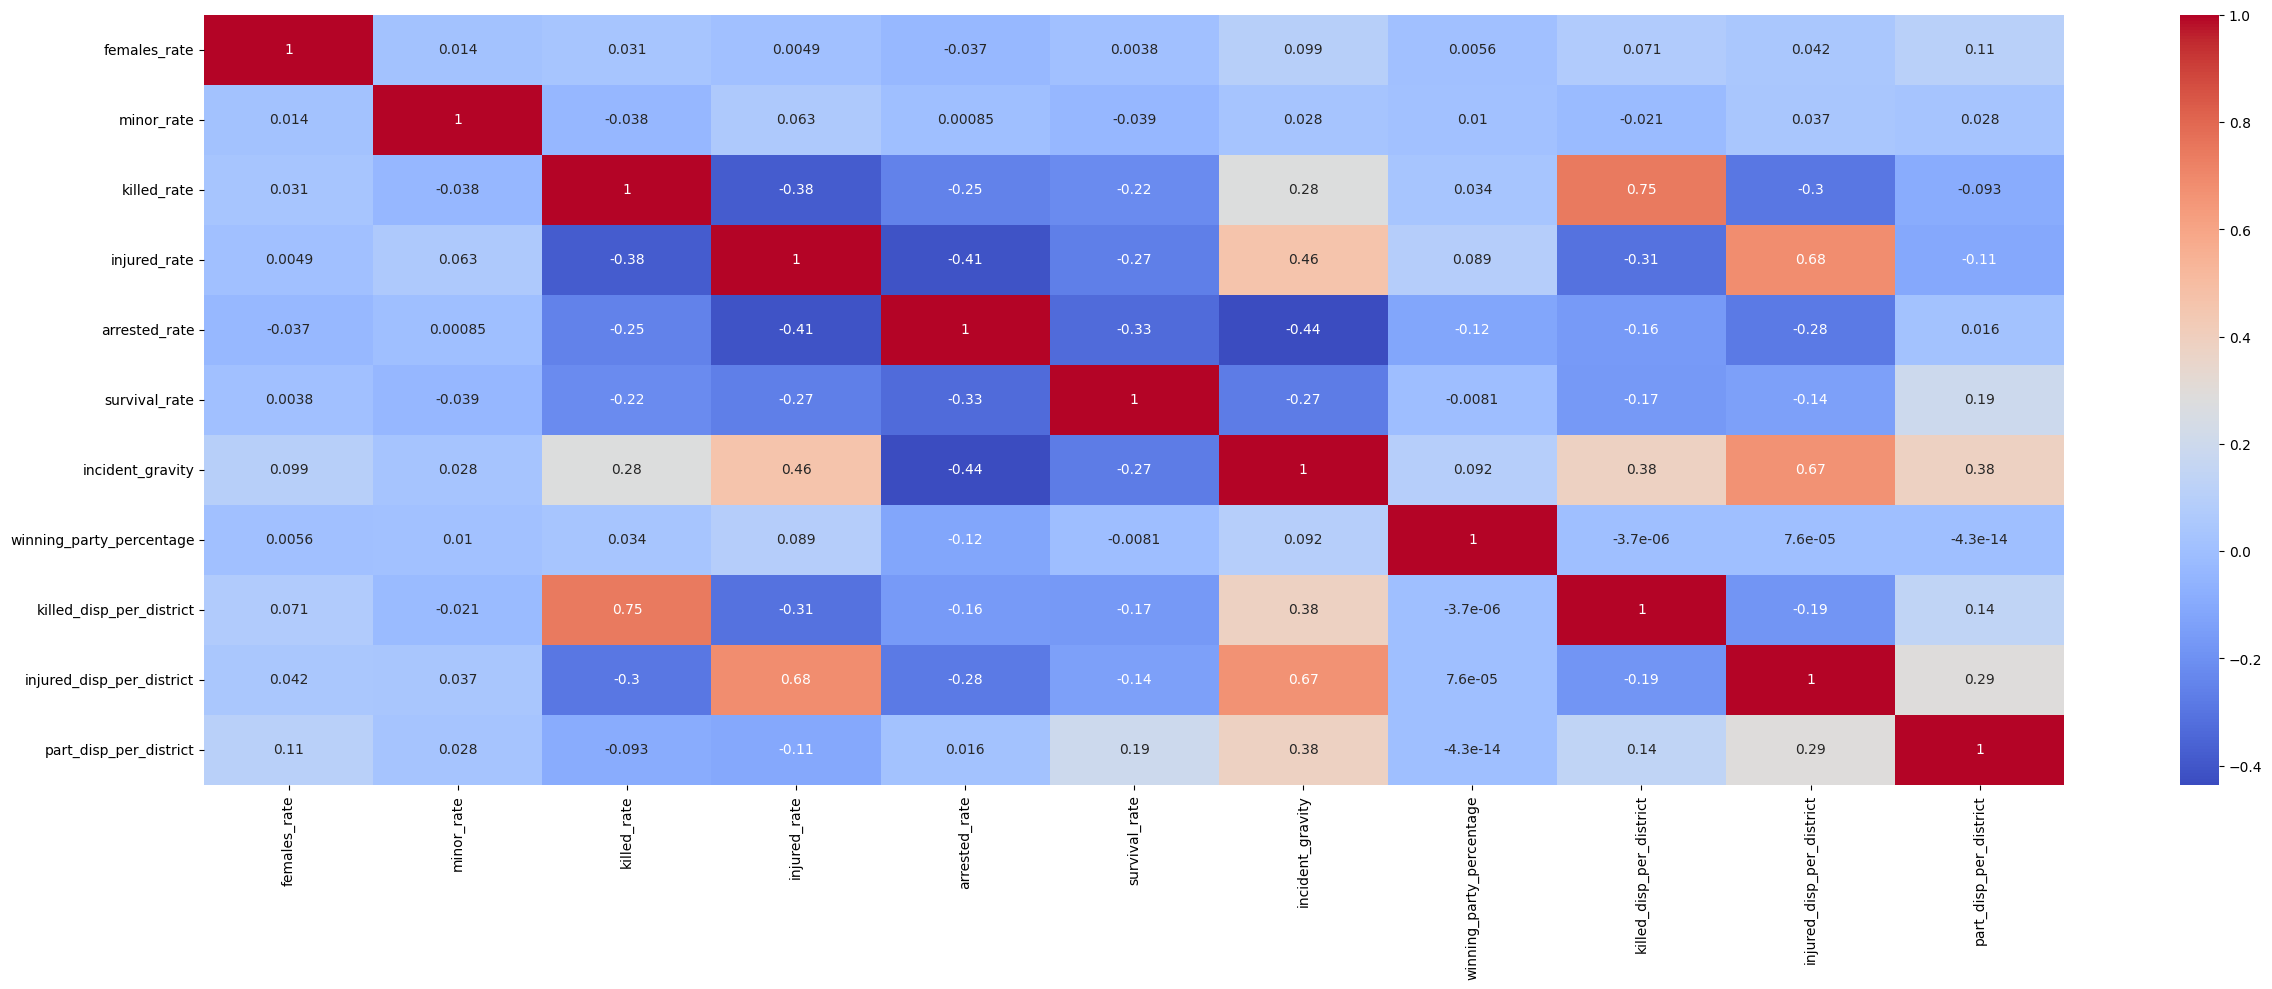

In [74]:
plt.figure(figsize=(30, 10))
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

#### Incident gravity

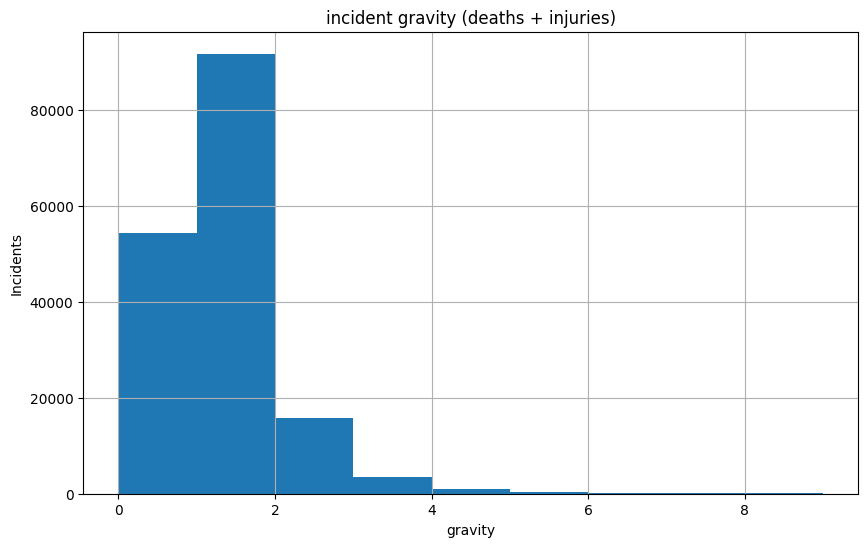

In [75]:
df['incident_gravity'].hist(figsize=(10,6), bins=[i for i in range(0,10,1)])
plt.title("incident gravity (deaths + injuries)")
plt.xlabel("gravity")
plt.ylabel("Incidents")
plt.show()

#### Incident ratios

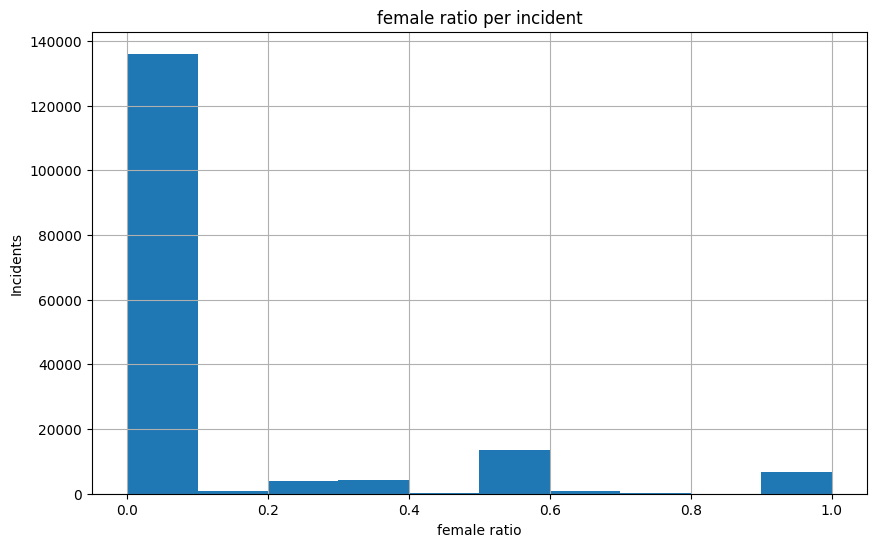

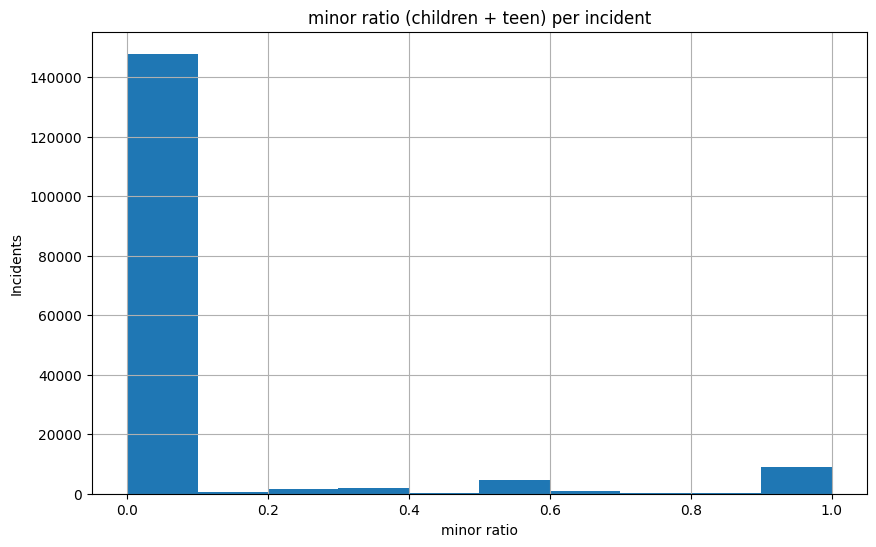

In [76]:
#Ratio of females people in the incidents w.r.t. the number of participants
df["females_rate"].hist(figsize=(10,6))
plt.title("female ratio per incident")
plt.xlabel("female ratio")
plt.ylabel("Incidents")
plt.show()
#Ratio of minors people in the incidents w.r.t. the number of participants
df["minor_rate"].hist(figsize=(10,6))
plt.title("minor ratio (children + teen) per incident")
plt.xlabel("minor ratio")
plt.ylabel("Incidents")
plt.show()


Females and minors ratio per incident have similar behaviors, for mostly of incidents indeed no female or minor is involved, but mainly males as seen in data understanding. However, there are a few number of incidents in which there are at least 1 female or minor (see 20-60% part) and some incidents involving only females or minors (see 100% part)   

In [77]:
print(df[df['n_females'] > 0]["females_rate"].value_counts().head(10))

print(f"\nTotal: {df[df['n_females'] > 0]['females_rate'].value_counts().sum()}")

females_rate
0.5         13358
1.0          6607
0.333333     4218
0.25         2794
0.2          1155
0.666667      975
0.166667      451
0.4           299
0.142857      216
0.75          121
Name: count, dtype: Int64

Total: 30633


In [78]:
print(df[(df['n_participants_child'] + df['n_participants_teen'])  > 0]["minor_rate"].value_counts().head(10))

print(f"\nTotal: {df[(df['n_participants_child'] + df['n_participants_teen'])  > 0]['minor_rate'].value_counts().sum()}")

minor_rate
1.0         8889
0.5         4350
0.333333    1785
0.2          920
0.666667     763
0.25         730
0.166667     373
0.75         206
0.4          189
0.142857     160
Name: count, dtype: Int64

Total: 18839


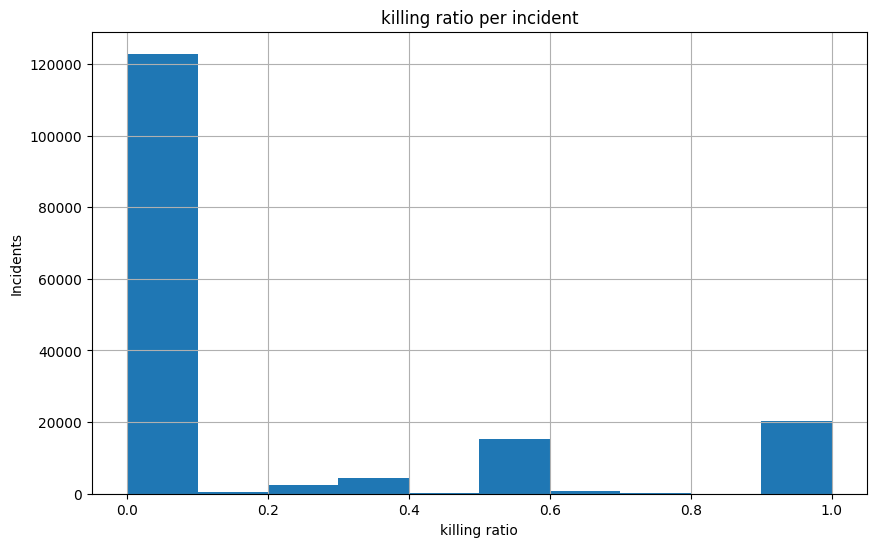

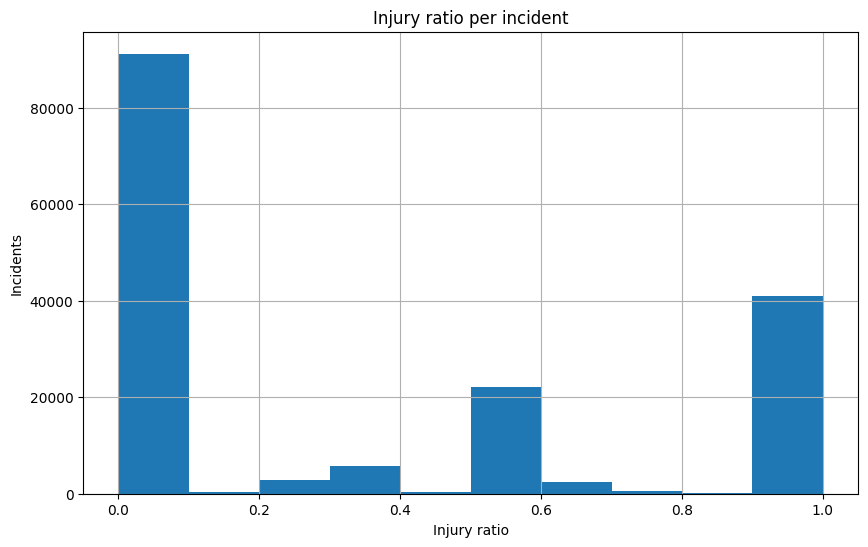

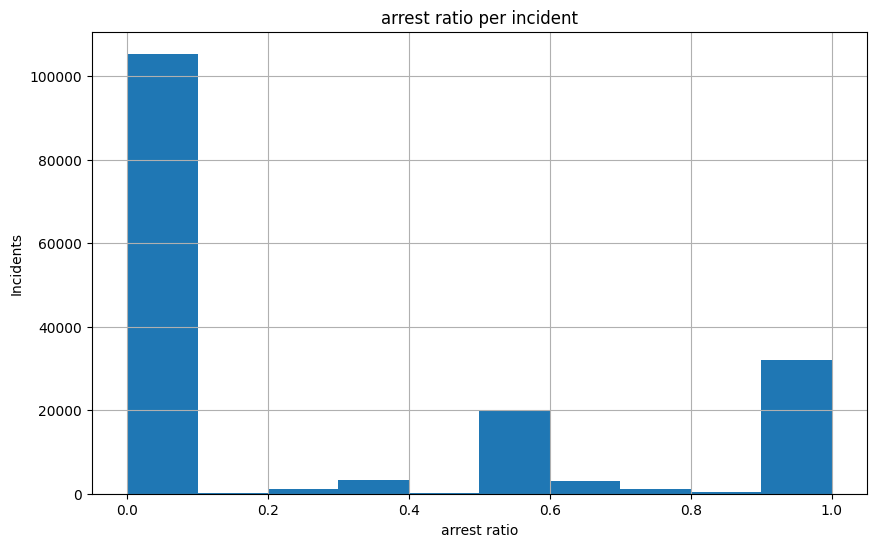

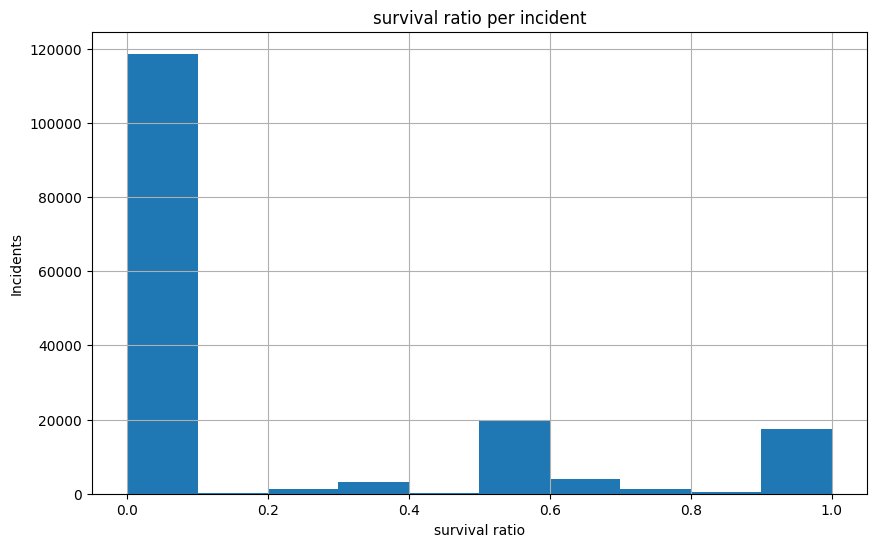

In [79]:

#Ratio of killed people in the incidents w.r.t. the number of participants
df["killed_rate"].hist(figsize=(10,6))
plt.title("killing ratio per incident")
plt.xlabel("killing ratio")
plt.ylabel("Incidents")
plt.show()
#Ratio of injured people in the incidents w.r.t. the number of participants
df["injured_rate"].hist(figsize=(10,6))
plt.title("Injury ratio per incident")
plt.xlabel("Injury ratio")
plt.ylabel("Incidents")
plt.show()

#Ratio of arrested people in the incidents w.r.t. the number of participants
df["arrested_rate"].hist(figsize=(10,6))
plt.title("arrest ratio per incident")
plt.xlabel("arrest ratio")
plt.ylabel("Incidents")
plt.show()
#Ratio of survival people in the incidents w.r.t. the number of participants
df["survival_rate"].hist(figsize=(10,6))
plt.title("survival ratio per incident")
plt.xlabel("survival ratio")
plt.ylabel("Incidents")
plt.show()

Although we clean the data, we see that mostly of incidents do not involve killing or injury or arrest or survived. Analyzing better the actual values of the distribution we can see for example:

In [80]:
df[["n_killed","n_injured","n_arrested","n_unharmed","n_participants","killed_rate"]].value_counts().head(10)

n_killed  n_injured  n_arrested  n_unharmed  n_participants  killed_rate
0.0       1.0        0.0         0.0         1.0             0.0            32141
          0.0        1.0         0.0         1.0             0.0            23382
1.0       0.0        0.0         0.0         1.0             1.0            17214
0.0       1.0        0.0         1.0         2.0             0.0             9922
          0.0        0.0         1.0         1.0             0.0             7799
1.0       0.0        1.0         0.0         2.0             0.5             7503
0.0       1.0        1.0         0.0         2.0             0.0             7002
          2.0        0.0         0.0         2.0             0.0             4770
          0.0        0.0         2.0         2.0             0.0             4732
1.0       0.0        0.0         1.0         2.0             0.5             4336
Name: count, dtype: int64

For killing rate, a lot of incidents involving injuries or arrests or survivors, do not involve any deaths

In [81]:
df[["n_killed","n_injured","n_arrested","n_unharmed","n_participants","survival_rate"]].value_counts().head(10)

n_killed  n_injured  n_arrested  n_unharmed  n_participants  survival_rate
0.0       1.0        0.0         0.0         1.0             0.0              32141
          0.0        1.0         0.0         1.0             0.0              23382
1.0       0.0        0.0         0.0         1.0             0.0              17214
0.0       1.0        0.0         1.0         2.0             0.5               9922
          0.0        0.0         1.0         1.0             1.0               7799
1.0       0.0        1.0         0.0         2.0             0.0               7503
0.0       1.0        1.0         0.0         2.0             0.0               7002
          2.0        0.0         0.0         2.0             0.0               4770
          0.0        0.0         2.0         2.0             1.0               4732
1.0       0.0        0.0         1.0         2.0             0.5               4336
Name: count, dtype: int64

The same for injured rate, a lot of incidents involving injuries or arrests or deaths, do not involve any survivors

In [82]:
df[["n_killed","n_injured","n_arrested","n_unharmed","n_participants","arrested_rate"]].value_counts().head(10)

n_killed  n_injured  n_arrested  n_unharmed  n_participants  arrested_rate
0.0       1.0        0.0         0.0         1.0             0.0              32141
          0.0        1.0         0.0         1.0             1.0              23382
1.0       0.0        0.0         0.0         1.0             0.0              17214
0.0       1.0        0.0         1.0         2.0             0.0               9922
          0.0        0.0         1.0         1.0             0.0               7799
1.0       0.0        1.0         0.0         2.0             0.5               7503
0.0       1.0        1.0         0.0         2.0             0.5               7002
          2.0        0.0         0.0         2.0             0.0               4770
          0.0        0.0         2.0         2.0             0.0               4732
1.0       0.0        0.0         1.0         2.0             0.0               4336
Name: count, dtype: int64

The same also can be said for arrested rate (and injured rate). So these attribute distribution, confirming the correlation analysis, are quite uncorrelated (and slightly anti-correlated)

In [83]:
print(df[df['n_injured'] > 0]["injured_rate"].value_counts().head(10))

print(f"\nTotal: {df[df['n_injured'] > 0][['injured_rate']].value_counts().sum()}")

injured_rate
1.0         40920
0.5         21777
0.333333     5754
0.666667     2461
0.25         2005
0.2           705
0.75          498
0.4           315
0.166667      231
0.6           213
Name: count, dtype: Int64

Total: 75449


A slight difference in the distributions of the ratios is represented by injured rate which is 1 in 40% of the incidents

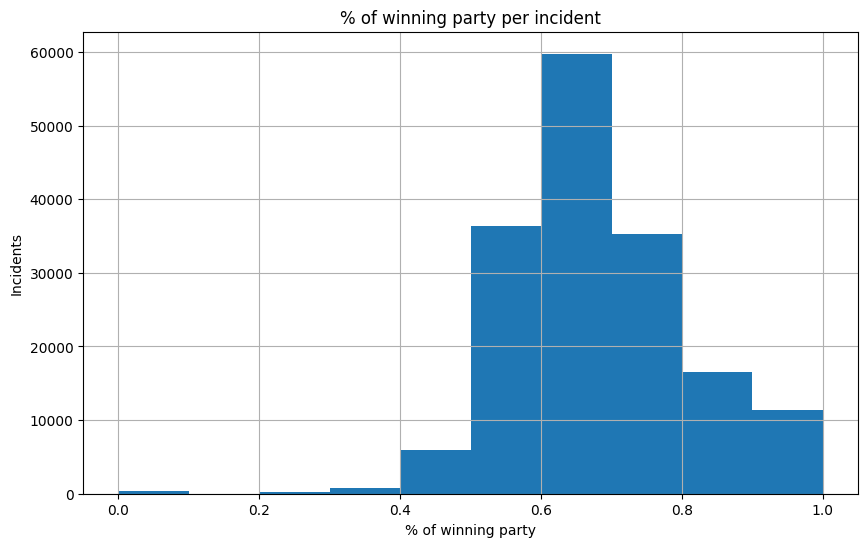

In [84]:
# Percentage of votes of the winning party
df['winning_party_percentage'].hist(figsize=(10,6))
plt.title("% of winning party per incident")
plt.xlabel("% of winning party")
plt.ylabel("Incidents")
plt.show()

In most of incidents, the majority party obtained a winning by 70% of total votes (clean win)

#### Incidents per district

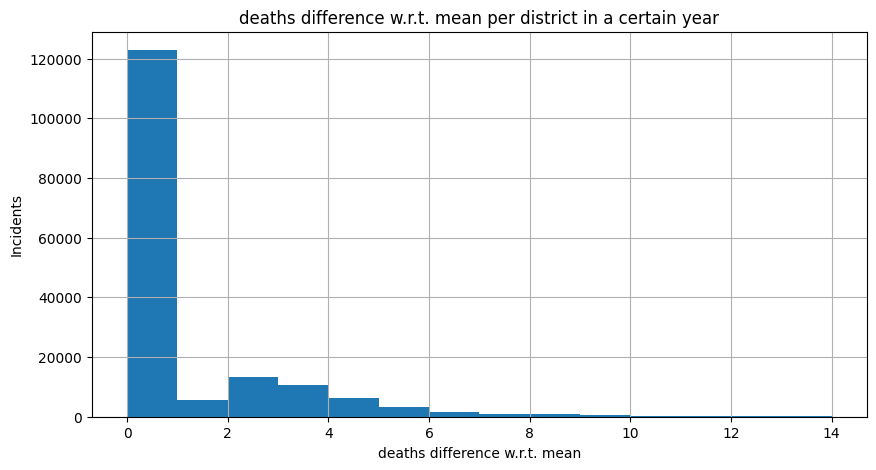

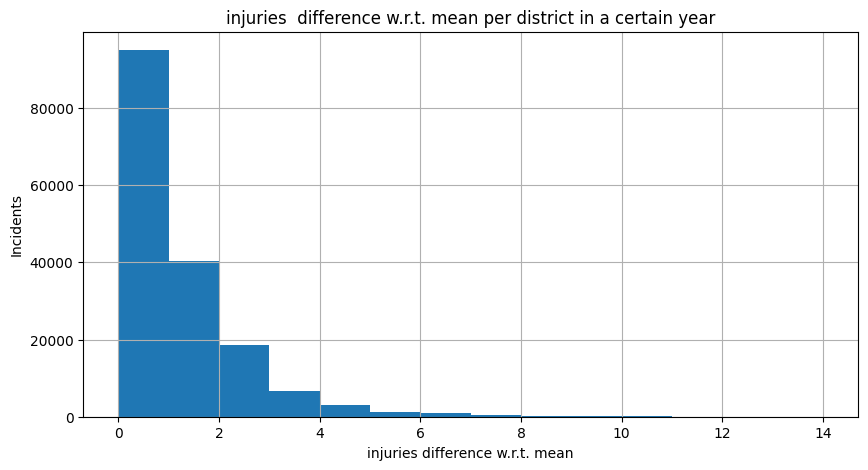

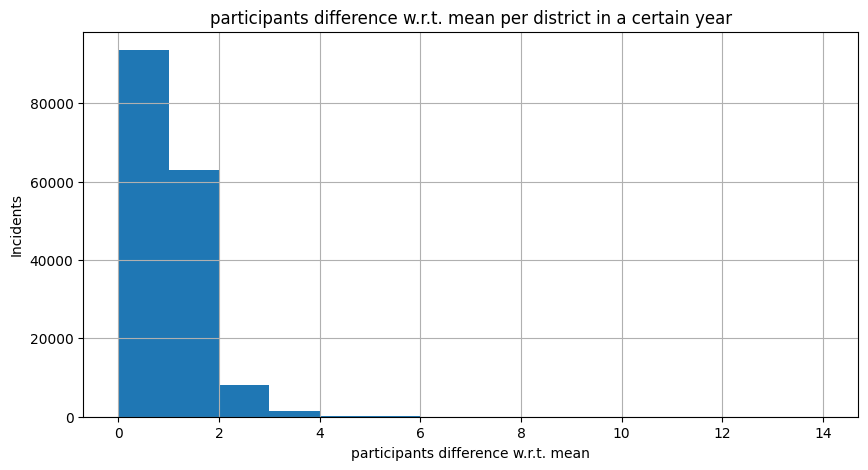

In [85]:
#How many killed people have been involved w.r.t the total killed people in the same congressional district in a given date
df["killed_disp_per_district"].hist(figsize=(10,5), bins=[i for i in range(0,15,1)])
plt.title("deaths difference w.r.t. mean per district in a certain year")
plt.xlabel("deaths difference w.r.t. mean")
plt.ylabel("Incidents")
plt.show()
#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["injured_disp_per_district"].hist(figsize=(10,5), bins=[i for i in range(0,15,1)])
plt.title("injuries  difference w.r.t. mean per district in a certain year")
plt.xlabel("injuries difference w.r.t. mean")
plt.ylabel("Incidents")
plt.show()
#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["part_disp_per_district"].hist(figsize=(10,5), bins=[i for i in range(0,15,1)])
plt.title("participants difference w.r.t. mean per district in a certain year")
plt.xlabel("participants difference w.r.t. mean")
plt.ylabel("Incidents")
plt.show()

Grouping by congressional district in a particular year, we can observe that the particular incidents has number of participants, number of deaths and injuries in most of the case aligned to the mean (considering that we insert 0 values when we encountered 0/0 divisions), as in many districts the mean is around 0.

In [86]:
df[col_to_plot].describe()

,females_rate,minor_rate,killed_rate,injured_rate,arrested_rate,survival_rate,incident_gravity,winning_party_percentage,killed_disp_per_district,injured_disp_per_district,part_disp_per_district
count,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0,166664.0
mean,0.10055,0.078393,0.184358,0.341893,0.27951,0.198233,0.843553,0.683179,0.999586,0.99979,1.0
std,0.240056,0.243292,0.342543,0.419948,0.399486,0.340317,0.796431,0.131461,2.067942,1.432749,0.604159
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283582
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.599002,0.0,0.0,0.583452
50%,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.67024,0.0,0.0,0.73917
75%,0.0,0.0,0.25,0.714286,0.5,0.5,1.0,0.752246,1.569231,1.687831,1.214612
max,1.0,1.0,1.0,1.0,1.0,1.0,25.0,1.0,53.5,34.576613,36.556856


As we can see from the count of the describe, the indicators has no missing values.  Moreover, we decide to keep also the outliers as they are coherent with the ones in the numeric attributes analyzed before.

We keep all the indicators because we think they describe better the incidents and they are at most moderately correlated

# Further Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [87]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166664 entries, 20871 to 185349
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  string        
 2   city_or_county             166664 non-null  string        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  Int64         
 6   avg_age_participants       166664 non-null  Float64       
 7   n_participants_child       166664 non-null  Int64         
 8   n_participants_teen        166664 non-null  Int64         
 9   n_females                  166664 non-null  Float64       
 10  n_killed                   166664 non-null  Float64       
 11  n_injured                  166664 non-null  Float64  

# Export the dataframe after the data preparation

In [89]:
df.to_csv('df_after_dp.csv', index=False)